<a href="https://colab.research.google.com/github/cnilsen/EEwPython/blob/master/KingCoEERestAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
PROJECT = 'tnd-data-v1'
!gcloud auth login --project {PROJECT}


Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=H81u6lOPHYjin6KumPDKIPDtZrAXJdNxe2xG1oEJ3Lc&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


Enter verification code: 4/sgEse7DXkUHLCsrc6gmrdDUOiggjdx5T9w4FhVwWnmbSY7IP7-NNjUk
If you need to use ADC, see:
  gcloud auth application-default --help

You are now logged in as [cnilsen@gmail.com].
Your current project is [tnd-data-v1].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [0]:
SERVICE_ACCOUNT='tnc-data-v1@appspot.gserviceaccount.com'
KEY =  'tncKey.json'
!gcloud iam service-accounts keys create {KEY} --iam-account {SERVICE_ACCOUNT}



created key [4639d6e31b1f1c19bf8ca0852cb1ed349e63058d] of type [json] as [tncKey.json] for [tnc-data-v1@appspot.gserviceaccount.com]


In [0]:
print(tncKey.json)

NameError: ignored

In [0]:
from google.auth.transport.requests import AuthorizedSession
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file('tncKey.json')
scoped_credentials = credentials.with_scopes(
    ['https://www.googleapis.com/auth/cloud-platform'])

session = AuthorizedSession(scoped_credentials)

url = 'https://earthengine.googleapis.com/v1alpha/projects/earthengine-public/assets/LANDSAT'

response = session.get(url)

from pprint import pprint
import json
pprint(json.loads(response.content))
print(url)

{'id': 'LANDSAT',
 'name': 'projects/earthengine-public/assets/LANDSAT',
 'type': 'FOLDER'}
https://earthengine.googleapis.com/v1alpha/projects/earthengine-public/assets/LANDSAT


In [0]:
var image = ee.Image("WWF/HydroSHEDS/03DIR");

## Query the flow direction raster

In [0]:
import urllib


center = [-121.9836, 47.5480]
coords = [-122.085, 37.422]


project = 'projects/earthengine-public'
asset_id = 'COPERNICUS/S2'
name = '{}/assets/{}'.format(project, asset_id)
url = 'https://earthengine.googleapis.com/v1alpha/{}:listImages?{}'.format(
  name, urllib.parse.urlencode({
    'startTime': '2017-04-01T00:00:00.000Z',
    'endTime': '2017-05-01T00:00:00.000Z',
    'region': '{"type":"Point", "coordinates":' + str(coords) + '}',
    'filter': 'CLOUDY_PIXEL_PERCENTAGE < 50',
}))

response = session.get(url)
content = response.content

pprint(response)
pprint(url)



<Response [200]>
'https://earthengine.googleapis.com/v1alpha/projects/earthengine-public/assets/COPERNICUS/S2:listImages?startTime=2017-04-01T00%3A00%3A00.000Z&endTime=2017-05-01T00%3A00%3A00.000Z&region=%7B%22type%22%3A%22Point%22%2C+%22coordinates%22%3A%5B-122.085%2C+37.422%5D%7D&filter=CLOUDY_PIXEL_PERCENTAGE+%3C+50'


In [0]:
for asset in json.loads(content)['images']:
    id = asset['id']
    cloud_cover = asset['properties']['CLOUDY_PIXEL_PERCENTAGE']
    print('%s : %s' % (id, cloud_cover))


COPERNICUS/S2/20170420T184921_20170420T190203_T10SEG : 4.3166
COPERNICUS/S2/20170430T190351_20170430T190351_T10SEG : 0


In [0]:
asset_id = 'COPERNICUS/S2/20170430T190351_20170430T190351_T10SEG'
name = '{}/assets/{}'.format(project, asset_id)
url = 'https://earthengine.googleapis.com/v1alpha/{}'.format(name)

response = session.get(url)
content = response.content

asset = json.loads(content)
print('Band Names: %s' % ','.join(band['id'] for band in asset['bands']))
print('First Band: %s' % json.dumps(asset['bands'][0], indent=2, sort_keys=True))


Band Names: B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,QA10,QA20,QA60
First Band: {
  "dataType": {
    "precision": "INT",
    "range": {
      "max": 65535
    }
  },
  "grid": {
    "affineTransform": {
      "scaleX": 60,
      "scaleY": -60,
      "translateX": 499980,
      "translateY": 4200000
    },
    "crsCode": "EPSG:32610",
    "dimensions": {
      "height": 1830,
      "width": 1830
    }
  },
  "id": "B1",
  "pyramidingPolicy": "MEAN"
}


In [0]:
import numpy
import io

name = '{}/assets/{}'.format(project, asset_id)
url = 'https://earthengine.googleapis.com/v1alpha/{}:getPixels'.format(name)
body = json.dumps({
    'fileFormat': 'NPY',
    'bandIds': ['B2', 'B3', 'B4', 'B8'],
    'grid': {
        'affineTransform': {
            'scaleX': 10,
            'scaleY': -10,
            'translateX': 499980,
            'translateY': 4200000,
        },
        'dimensions': {'width': 256, 'height': 256},
    },
})

pixels_response = session.post(url, body)
pixels_content = pixels_response.content

array = numpy.load(io.BytesIO(pixels_content))
print('Shape: %s' % (array.shape,))
print('Data:')
print(array)


Shape: (256, 256)
Data:
[[( 899, 586, 351, 189) ( 918, 630, 501, 248) (1013, 773, 654, 378) ...
  (1014, 690, 419, 323) ( 942, 657, 424, 260) ( 987, 691, 431, 315)]
 [( 902, 630, 541, 227) (1059, 866, 719, 429) (1195, 922, 626, 539) ...
  ( 978, 659, 404, 287) ( 954, 672, 426, 279) ( 990, 678, 397, 304)]
 [(1050, 855, 721, 419) (1257, 977, 635, 569) (1137, 770, 400, 435) ...
  ( 972, 674, 421, 312) (1001, 688, 431, 311) (1004, 659, 378, 284)]
 ...
 [( 969, 672, 375, 275) ( 927, 680, 478, 294) (1018, 724, 455, 353) ...
  ( 924, 659, 375, 232) ( 921, 664, 438, 273) ( 966, 737, 521, 306)]
 [( 920, 645, 391, 248) ( 979, 728, 481, 327) ( 997, 708, 425, 324) ...
  ( 927, 673, 387, 243) ( 927, 688, 459, 284) ( 962, 732, 509, 331)]
 [( 978, 723, 449, 330) (1005, 712, 446, 314) ( 946, 667, 393, 269) ...
  ( 949, 692, 413, 271) ( 927, 689, 472, 285) ( 966, 742, 516, 331)]]


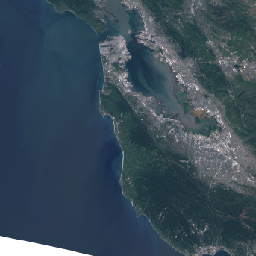

In [0]:
url = 'https://earthengine.googleapis.com/v1alpha/{}:getPixels'.format(name)
body = json.dumps({
    'fileFormat': 'PNG',
    'bandIds': ['B4', 'B3', 'B2'],
    'region': asset['geometry'],
    'grid': {
        'dimensions': {'width': 256, 'height': 256},
    },
    'visualizationOptions': {
        'ranges': [{'min': 0, 'max': 3000}],
    },
})

image_response = session.post(url, body)
image_content = image_response.content

from IPython.display import Image
Image(image_content)
